# Example 6: Fault evolution
This example describes how to correlate faults extracted at different time steps.

## Setup

1. First, you will need sign in to your Google account. If you're not signed in, you can sign in [here](https://myaccount.google.com/?utm_source=sign_in_no_continue)
2. Next, head on to the [Colab Welcome Page](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true).
3. There, select Github in the top tab and search for https://github.com/thilowrona/fault_analysis_toolbox/blob/master/examples/2-fault_properties/2-fault_properties.ipynb
4. Clicking opens this notebook. This is a Jupyter notebook; an awesome combination of code and documentation allowing us work on, describe and share our projects.
5. When you run the first cell, you will face a pop-up saying ‘Warning: This notebook was not authored by Google’; you should click on ‘Run Anyway’ to get rid of the warning.
6. Next we want to save our notebook. If you click on ‘File’ and then ‘Save’, you will see a pop-up saying ´CANNOT SAVE CHANGES´. Now, click on ‘SAVE A COPY IN DRIVE’. This opens up a new tab with the same file, but this time located in your Drive. If you want to continue working after saving, use the file in the new tab. Your notebook will be saved in a folder called Colab Notebooks in your Google Drive by default.

## Load packages
To run the toolbox, we will need a couple of packages including the toolbox itself. So let's install them:

In [1]:
!git clone https://github.com/thilowrona/fault_analysis_toolbox

Cloning into 'fault_analysis_toolbox'...
remote: Enumerating objects: 2498, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 2498 (delta 0), reused 0 (delta 0), pack-reused 2494
Receiving objects: 100% (2498/2498), 371.52 MiB | 27.31 MiB/s, done.
Resolving deltas: 100% (580/580), done.


In [2]:
!pip3 install vtk
!pip3 install git+https://github.com/ulikoehler/cv_algorithms.git

     |████████████████████████████████| 103.4MB 59kB/s 
  Cloning https://github.com/ulikoehler/cv_algorithms.git to /tmp/pip-req-build-l65ffa1a
  Running command git clone -q https://github.com/ulikoehler/cv_algorithms.git /tmp/pip-req-build-l65ffa1a
  Created wheel for cv-algorithms: filename=cv_algorithms-1.0.0-cp37-cp37m-linux_x86_64.whl size=43516 sha256=30deba1add91d5ef593e325419b19233f5733f8b21b618746bc61993254381bd
  Stored in directory: /tmp/pip-ephem-wheel-cache-jdq14w0y/wheels/0b/45/f6/dfa0d535f50a0148a4c7d6912942fdb7a6445d7196a2591cbe
Successfully built cv-algorithms


Now we can load the python packages:

In [3]:
import numpy as np 
import networkx as nx
import pickle

import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

from sys import stdout

and the functions from the fault analysis toolbox that we want to use:

In [4]:
import sys
sys.path.append('/content/fault_analysis_toolbox/code/')

from image_processing import guo_hall
from edits import *
from metrics import *
from plots import *

## Load and plot faults

First, we load our fault networks extracted from a 2-D model over several timesteps:

In [5]:
Gs = []
for n in range(3,50):
  Gs.append(pickle.load(open('/content/fault_analysis_toolbox/examples/6-evolution/graphs/g_'+ str(n) + '.p', 'rb')))

Now we can visualize these faults:

In [6]:
%matplotlib inline
from ipywidgets import interactive, widgets, Layout


def f(time):
    fig, ax = plt.subplots(figsize=(16,4))
    plot_faults(Gs[time], ax, label=False)
    plt.xlim([1000, 3500])
    plt.ylim([600, 0])
    plt.show()

interactive_plot = interactive(f, time=widgets.IntSlider(min=3, max=49, step=1, layout=Layout(width='900px')))
output = interactive_plot.children[-1]
output.layout.width = '1000px'
interactive_plot

interactive(children=(IntSlider(value=3, description='time', layout=Layout(width='900px'), max=49, min=3), Out…

## Loop through time
One of the easiest ways to follow the evolution of our faults is to track them through time. All we need to do is:

1.   Loop through time
2.   Get fault labels
3.   Visualize them



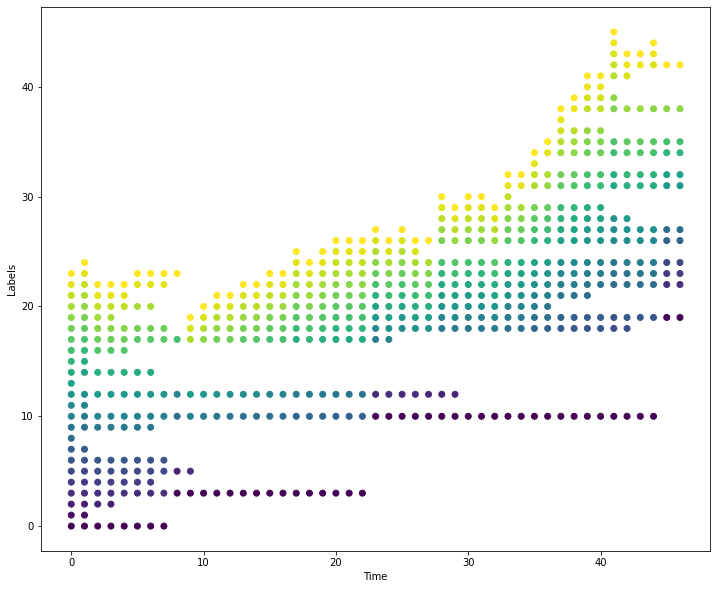

In [7]:
plt.figure(figsize=(12,10))

for time, G in enumerate(Gs):
  labels = get_fault_labels(G)
  plt.scatter(time*np.ones_like(labels), labels, c=labels)

plt.xlabel('Time')
plt.ylabel('Labels')
plt.show()

This shows us how long each of the faults lives. If we collapse this plot, we get a histogram of the number of faults with time:

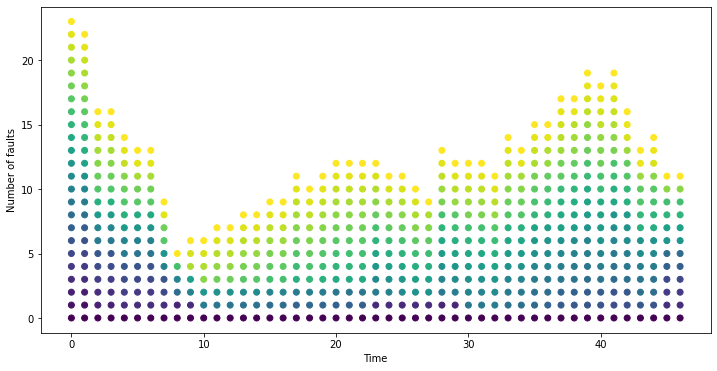

In [8]:
plt.figure(figsize=(12,6))

for time, G in enumerate(Gs):
  labels = get_fault_labels(G)
  plt.scatter(time*np.ones_like(labels), np.arange(len(labels)), c=labels)

plt.xlabel('Time')
plt.ylabel('Number of faults')
plt.show()

We can also track fault properties, e.g. fault length or maximum displacement:

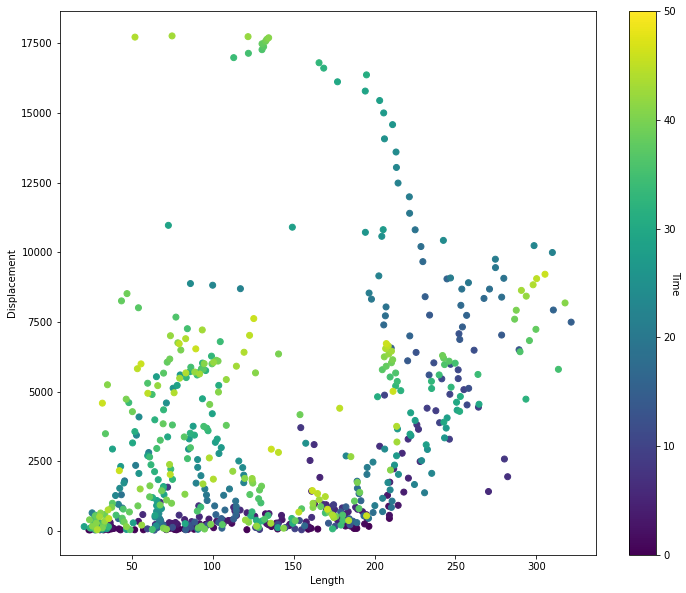

In [26]:
plt.figure(figsize=(12,10))

for time, G in enumerate(Gs):
  labels = get_fault_labels(G)

  lengths = []
  for label in labels:
    lengths.append(total_length(get_fault(G, label)))

  max_dis = []
  for label in labels:
    max_dis.append(max_value_nodes(get_fault(G, label), 'displacement'))

  plt.scatter(lengths, max_dis, c=time*np.ones_like(labels), vmin=0, vmax=50)

cbar = plt.colorbar()
cbar.ax.set_ylabel('Time', rotation=270)
plt.xlabel('Length')
plt.ylabel('Displacement')
plt.show()

Now it becomes difficult to follow the growth of individual faults. We can't really see how these data points are connected, how faults merge or split up. How could we keep track of these processes?

We could define another graph, which captures the evolution of the fault network through time. Let's start from here:

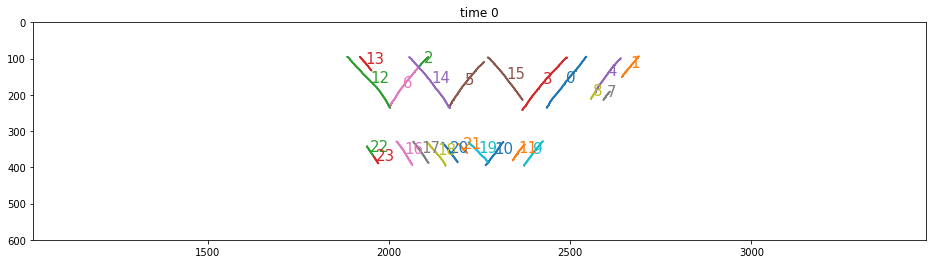

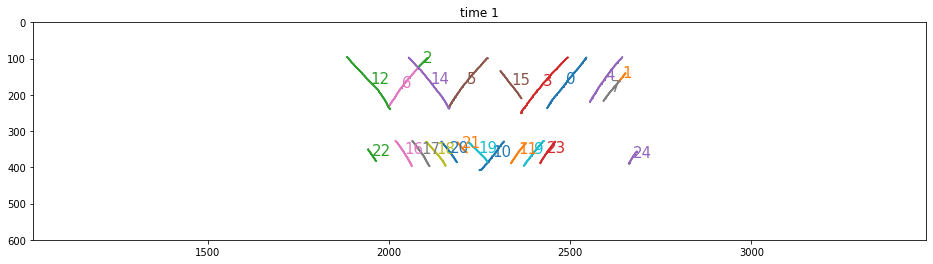

In [56]:
time = 0

G_0 = Gs[time]
G_1 = Gs[time+1]

fig, ax = plt.subplots(figsize=(16,4))
plot_faults(G_0, ax, label=True)
plt.title('time 0')
plt.xlim([1000, 3500])
plt.ylim([600, 0])
plt.show()

fig, ax = plt.subplots(figsize=(16,4))
plt.title('time 1')
plot_faults(G_1, ax, label=True)
plt.xlim([1000, 3500])
plt.ylim([600, 0])
plt.show()

In [57]:
H = nx.Graph()

def H_add_nodes(H, G, time):
  
    for cc in sorted(nx.connected_components(G)):
        for node in cc:
            label = G.nodes[node]['component']
            H.add_node((time, label))
            
            H.nodes[(time, label)]['pos'] = (time, label)
            H.nodes[(time, label)]['time'] = time
            H.nodes[(time, label)]['fault'] = G.nodes[node]['fault']
            H.nodes[(time, label)]['component'] = G.nodes[node]['component']
        
            break
    
        G_cc = nx.subgraph(G, cc)
        
        H.nodes[(time, label)]['length'] = total_length(G_cc)
        H.nodes[(time, label)]['displacement'] = max_value_nodes(G_cc, 'displacement')
        
    return H 

H = H_add_nodes(H, G_0, 0)
H = H_add_nodes(H, G_1, 1)  

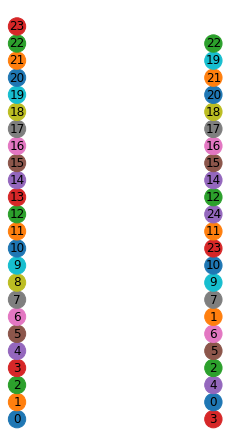

In [58]:
plt.figure(figsize=(3,6))
nx.draw(H,
        pos = nx.get_node_attributes(H, 'pos'),
        labels=nx.get_node_attributes(H, 'fault'),
        with_labels=True,
        node_color = get_node_colors(H, 'fault'))

Now we want to connect the components which belong to the same fault, i.e. have the same label in the above plot. For this purpose, we create a dictionary of the components belonging to each fault:

In [59]:
def get_dictionary(G):
    faults = get_fault_labels(G)        
    dic = {}
    for fault in faults:
        G_fault = get_fault(G, fault)
        components = set()
        for node in G_fault:
            components.add(G_fault.nodes[node]['component'])
        dic[fault] = sorted(list(components))
    return dic


dic_0 = get_dictionary(G_0)
dic_1 = get_dictionary(G_1)

print(dic_0)

{0: [0], 1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 10: [10], 11: [11], 12: [12], 13: [13], 14: [14], 15: [15], 16: [16], 17: [17], 18: [18], 19: [19], 20: [20], 21: [21], 22: [22], 23: [23]}


Now we compute the faults common between consecutive time steps:

In [60]:
faults_0 = get_fault_labels(G_0)
faults_1 = get_fault_labels(G_1)

common_faults = list(set(faults_0).intersection(set(faults_1)))

Next we loop through the common faults, get the components for time 0 (starts) and time 1 (ends) and connect the components. This is a bit complicated because we can have different numbers of components, e.g. sometimes the fault has only one component at time 0 (len(starts)==1) and one at time 1 (len(ends)==1), then we can simply add an edge, but if there are multiple components to each fault, we need add multiple edges:

In [61]:
for fault in common_faults:
    starts = dic_0[fault]
    ends   = dic_1[fault]
    if len(starts) == 1 and len(ends) == 1:
        H.add_edge((time, starts[0]), (time+1, ends[0]))
    elif len(starts) == 1 and len(ends) > 1:
        for end in ends:
            H.add_edge((time, starts[0]), (time+1, end))
    elif len(starts) > 1 and len(ends) == 1:
          for start in starts:
            H.add_edge((time, start), (time+1, ends[0]))
    elif len(starts) > 1 and len(ends) > 1:
        if len(starts) == len(ends):
            for start, end in zip(starts, ends):
                H.add_edge((time, start), (time+1, end))
        elif len(starts) < len(ends):
            minimum = min(len(starts), len(ends))
            difference = len(ends)-len(starts)
            for n in range(minimum):
                H.add_edge((time, starts[n]), (time+1, ends[n]))
            for n in range(difference):
                H.add_edge((time, starts[minimum-1]), (time+1, ends[minimum-1+n+1]))
        elif len(starts) > len(ends):
            minimum = min(len(starts), len(ends))
            difference = len(starts)-len(ends)                
            for n in range(minimum):
                H.add_edge((time, starts[n]), (time+1, ends[n]))                
            for n in range(difference):
                H.add_edge((time, starts[minimum-1+n+1]), (time+1, ends[minimum-1])) 

Now let's look at the result:

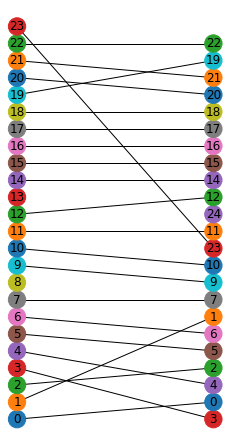

In [63]:
plt.figure(figsize=(3,6))
nx.draw(H,
        pos = nx.get_node_attributes(H, 'pos'),
        labels=nx.get_node_attributes(H, 'fault'),
        with_labels=True,
        node_color = get_node_colors(H, 'fault'))

Excellent! Let's do this for all time steps:

In [65]:
H = nx.Graph()

for time in range(0, len(Gs)-1):

  print(time)

  G_0 = Gs[time]
  G_1 = Gs[time+1]

  if time == 0:
    H = H_add_nodes(H, G_0, time)  
  H = H_add_nodes(H, G_1, time+1)  

  faults_0 = get_fault_labels(G_0)
  faults_1 = get_fault_labels(G_1) 

  dic_0 = get_dictionary(G_0)
  dic_1 = get_dictionary(G_1)
          
  
  faults = list(set(faults_0).intersection(set(faults_1)))


  for fault in faults:
      starts = dic_0[fault]
      ends   = dic_1[fault]
      if len(starts) == 1 and len(ends) == 1:
          H.add_edge((time, starts[0]), (time+1, ends[0]))
      elif len(starts) == 1 and len(ends) > 1:
          for end in ends:
              H.add_edge((time, starts[0]), (time+1, end))
      elif len(starts) > 1 and len(ends) == 1:
            for start in starts:
              H.add_edge((time, start), (time+1, ends[0]))
      elif len(starts) > 1 and len(ends) > 1:
          if len(starts) == len(ends):
              for start, end in zip(starts, ends):
                  H.add_edge((time, start), (time+1, end))
          elif len(starts) < len(ends):
              minimum = min(len(starts), len(ends))
              difference = len(ends)-len(starts)
              for n in range(minimum):
                  H.add_edge((time, starts[n]), (time+1, ends[n]))
              for n in range(difference):
                  H.add_edge((time, starts[minimum-1]), (time+1, ends[minimum-1+n+1]))
          elif len(starts) > len(ends):
              minimum = min(len(starts), len(ends))
              difference = len(starts)-len(ends)                
              for n in range(minimum):
                  H.add_edge((time, starts[n]), (time+1, ends[n]))                
              for n in range(difference):
                  H.add_edge((time, starts[minimum-1+n+1]), (time+1, ends[minimum-1]))     

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45


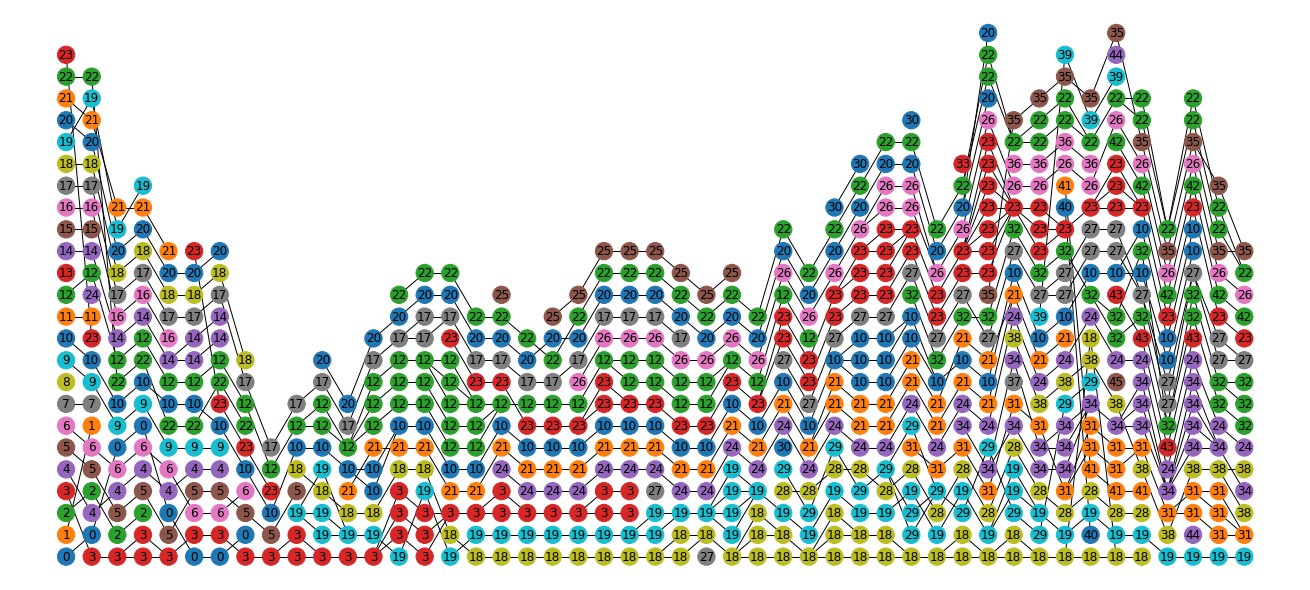

In [66]:
plt.figure(figsize=(18,8))
nx.draw(H,
        pos = nx.get_node_attributes(H, 'pos'),
        labels=nx.get_node_attributes(H, 'fault'),
        with_labels=True,
        node_color = get_node_colors(H, 'fault'))